In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import shutil

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.gland import gland_data

%matplotlib inline

## Additional functions

In [33]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids, model, data_set):
    APs, IoUs = [], []
    for image_id in image_ids:
        # Load image
        try:
            image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(data_set, config,
                                       image_id)
            # Run object detection
            results = model.detect([image], verbose=0)
            # Compute AP
            r = results[0]
            AP, precisions, recalls, overlaps =\
                utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                  r['rois'], r['class_ids'], r['scores'], r['masks'])
            APs.append(AP)
            IoUs.append(overlaps)
        except:
            pass
    return APs, IoUs

def merged_mask(masks):
    """
    merge mask into one and return merged mask
    """
    n= masks.shape[2]
    
    if n!=0:        
        merged_mask = np.zeros((masks.shape[0], masks.shape[1]))
        for i in range(n):
            merged_mask+=masks[...,i]
        merged_mask=np.asarray(merged_mask,dtype=np.uint8)   
        return merged_mask
    return masks[:,:,0]
    

def compute_iou(predict_mask, gt_mask):
    """
    Computes Intersection over Union score for two binary masks.
    :param predict_mask: numpy array
    :param gt_mask: numpy array
    :type1 and type2 results are same
    :return iou score:
    """
    if predict_mask.shape[2]==0:
        return 0
    mask1 = merged_mask(predict_mask)
    mask2 = merged_mask(gt_mask)
    
    #type 1
    intersection = np.sum((mask1 + mask2) > 1)
    union = np.sum((mask1 + mask2) > 0)
    iou_score = intersection / float(union)
    #print("Iou 1 : ",iou_score)
    
    #type2
    intersection = np.logical_and(mask1, mask2)#*
    union = np.logical_or(mask1, mask2)# +
    iou_score = np.sum(intersection) / np.sum(union)
    #print("Iou 2 : ",iou_score)
    return iou_score

# calculate IoU for all images
def compute_batch_iou(image_ids, model, data_set):
    Iou = []
    for image_id in image_ids:
        try:
            # Load image
            image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(data_set, config,
                                       image_id)
            # Run object detection
            results = model.detect([image], verbose=0)
            # Compute IoU
            r = results[0]
            iou_score = compute_iou(r['masks'], gt_mask)
            Iou.append(iou_score)
        except:
            pass
    return Iou

def compute_dice_metric(iou):
    return 2 * iou/ (iou + 1)


## Configurations

In [4]:
DATASET_DIR = '/home/mkubita/Pulpit/projektBadawczy/Dataset_Model/'

In [5]:
config = gland_data.GlandConfig()

In [25]:
config_resnet50_28 = gland_data.GlandConfig()
config_resnet50_28.BACKBONE = "resnet50"
config_resnet50_28.USE_MINI_MASK = False


config_resnet50_56 = gland_data.GlandConfig()
config_resnet50_56.GPU_COUNT = 1
config_resnet50_56.IMAGES_PER_GPU = 1
config_resnet50_56.BACKBONE = "resnet50"
config_resnet50_56.USE_MINI_MASK = False



config_resnet50_84 = gland_data.GlandConfig()
config_resnet50_84.GPU_COUNT = 1
config_resnet50_84.IMAGES_PER_GPU = 1
config_resnet50_84.BACKBONE = "resnet50"
config_resnet50_84.USE_MINI_MASK = False


In [26]:
config_resnet101_28 = gland_data.GlandConfig()
config_resnet101_28.GPU_COUNT = 1
config_resnet101_28.IMAGES_PER_GPU = 1
config_resnet101_28.BACKBONE = "resnet101"
config_resnet101_28.USE_MINI_MASK = False

config_resnet101_56 = gland_data.GlandConfig()
config_resnet101_56.BACKBONE = "resnet101"
config_resnet101_56.USE_MINI_MASK = False

# config_resnet101_56.MINI_MASK_SHAPE = (56, 56)
# config_resnet101_56.USE_MINI_MASK = True
# config_resnet101_56.MASK_SHAPE = [56, 56]


config_resnet101_84 = gland_data.GlandConfig()
config_resnet101_84.BACKBONE = "resnet101"
config_resnet101_84.USE_MINI_MASK = False

# config_resnet101_84.MINI_MASK_SHAPE = (84, 84)
# config_resnet101_84.MASK_SHAPE = [56, 56]
# config_resnet101_84.USE_MINI_MASK = True

In [32]:
config_alexnet_28 = gland_data.GlandConfig()
config_alexnet_28.GPU_COUNT = 1
config_alexnet_28.IMAGES_PER_GPU = 1
config_alexnet_28.BACKBONE = "alexnet"
config_alexnet_28.USE_MINI_MASK = False


config_alexnet_56 = gland_data.GlandConfig()
config_alexnet_56.BACKBONE = "alexnet"
config_alexnet_56.USE_MINI_MASK = False


config_alexnet_84 = gland_data.GlandConfig()
config_alexnet_84.USE_MINI_MASK = False

config_alexnet_84.BACKBONE = "alexnet"

In [9]:
# config3 = gland_data.GlandConfig()
# config3.GPU_COUNT = 1
# config3.IMAGES_PER_GPU = 1
# config3.BACKBONE = "alexnet"

In [10]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [11]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Datasets

In [12]:
# Load dataset
dataset1 = gland_data.GlandDataset()
dataset1.load_gland(DATASET_DIR, "val")

dataset2 = gland_data.GlandDataset()
dataset2.load_gland(DATASET_DIR, "val2")

# Must call before using the dataset
dataset1.prepare()
dataset2.prepare()

print("Image Count: {}".format(len(dataset1.image_ids)))
print("Class Count: {}".format(dataset1.num_classes))
for i, info in enumerate(dataset1.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
    
print("Image Count: {}".format(len(dataset2.image_ids)))
print("Class Count: {}".format(dataset2.num_classes))
for i, info in enumerate(dataset2.class_info):
    print("{:3}. {:50}".format(i, info['name']))



Image Count: 56
Class Count: 2
  0. BG                                                
  1. gland                                             
Image Count: 18
Class Count: 2
  0. BG                                                
  1. gland                                             


## Load Models

In [36]:
# LOAD RESNET50
model_path1 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Resnet50_28_28/mask_rcnn_gland_0030(6).h5'
model_path2 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Resnet50_56_56/gland20220507T1203/mask_rcnn_gland_0025.h5'
model_path3 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Resnet50_84_84/mask_rcnn_gland_0030(8).h5'

model1 = modellib.MaskRCNN(mode="inference", model_dir=model_path1, config=config_resnet50_28)
model2 = modellib.MaskRCNN(mode="inference", model_dir=model_path2, config=config_resnet50_56)
model3 = modellib.MaskRCNN(mode="inference", model_dir=model_path3, config=config_resnet50_84)


model1.load_weights(model_path1, by_name=True)
model2.load_weights(model_path2, by_name=True)
model3.load_weights(model_path3, by_name=True)

In [ ]:
# LOAD RESNET101
model_path_resnet101_1 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Resnet101_28_28/Test2/mask_rcnn_gland_0045.h5'
model_path_resnet101_2 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Resnet101_56_56/mask_rcnn_gland_0030.h5'
model_path_resnet101_3 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Resnet101_84_84/Test2/mask_rcnn_gland_0045(1).h5'

model_resnet101_28 = modellib.MaskRCNN(mode="inference", model_dir=model_path_resnet101_1, config=config_resnet101_28)
model_resnet101_56 = modellib.MaskRCNN(mode="inference", model_dir=model_path_resnet101_2, config=config_resnet101_56)
model_resnet101_84 = modellib.MaskRCNN(mode="inference", model_dir=model_path_resnet101_3, config=config_resnet101_84)


model_resnet101_28.load_weights(model_path_resnet101_1, by_name=True)
model_resnet101_56.load_weights(model_path_resnet101_2, by_name=True)
model_resnet101_84.load_weights(model_path_resnet101_3, by_name=True)

In [ ]:
models_resnet101 = [model_resnet101_28, model_resnet101_56, model_resnet101_84]

In [35]:
# LOAD ALEXNET
model_path_alexnet_1 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Alexnet_28_28/mask_rcnn_gland_0030(3).h5'
model_path_alexnet_2 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Alexnet_56_56/mask_rcnn_gland_0030(1).h5'
model_path_alexnet_3 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Augmentation/Alexnet_84_84/mask_rcnn_gland_0030(7).h5'

model_alexnet1 = modellib.MaskRCNN(mode="inference", model_dir=model_path_alexnet_1, config=config_alexnet_28)
model_alexnet2 = modellib.MaskRCNN(mode="inference", model_dir=model_path_alexnet_2, config=config_alexnet_56)
model_alexnet3 = modellib.MaskRCNN(mode="inference", model_dir=model_path_alexnet_3, config=config_alexnet_84)


model_alexnet1.load_weights(model_path_alexnet_1, by_name=True)
model_alexnet2.load_weights(model_path_alexnet_2, by_name=True)
model_alexnet3.load_weights(model_path_alexnet_3, by_name=True)

In [ ]:
models_alexnet = [model_alexnet1, model_alexnet2, model_alexnet3]

In [28]:
# COMPARE AUGMENATION VS NO AUGMENTATION


model_resnet101_path = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/NoAugumentation/Resnet101_56_56/mask_rcnn_gland_0030.h5'
model_resnet50_path = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/NoAugumentation/Resnet50_56_56/mask_rcnn_gland_0030(14).h5'
model_alexnet_path = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/NoAugumentation/Alexnet_56/mask_rcnn_gland_0030(9).h5'


model_resnet101 = modellib.MaskRCNN(mode="inference", model_dir=model_resnet101_path, config=config_resnet101_56)
model_resnet50 = modellib.MaskRCNN(mode="inference", model_dir=model_resnet50_path, config=config_resnet101_56)
model_alexnet = modellib.MaskRCNN(mode="inference", model_dir=model_alexnet_path, config=config_alexnet_84)

model_resnet101.load_weights(model_resnet101_path, by_name=True)
model_resnet50.load_weights(model_resnet50_path, by_name=True)
model_alexnet.load_weights(model_alexnet_path, by_name=True)

models_no_augmentation = [model_resnet101, model_resnet50, model_alexnet]

## TEST

image ID: gland.testA_51.bmp (46) /home/mkubita/Pulpit/projektBadawczy/Dataset_Model/val/testA_51.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 

image ID: gland.testA_51.bmp (46) /home/mkubita/Pulpit/projektBadawczy/Dataset_Model/val/testA_51.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min

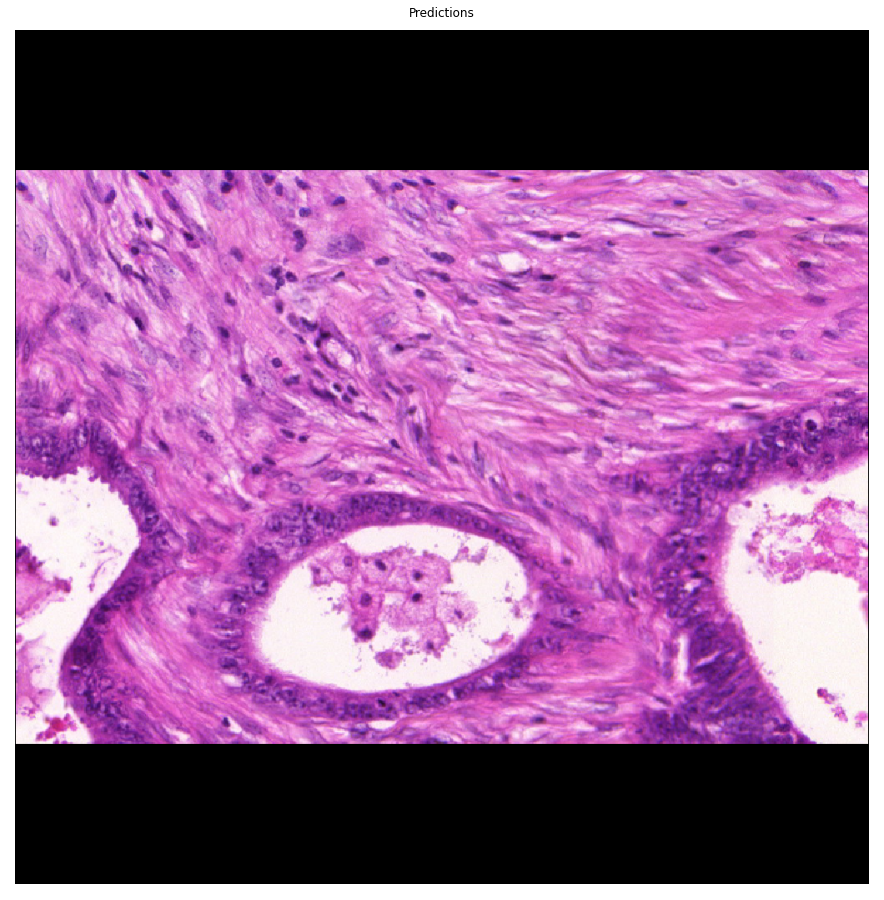

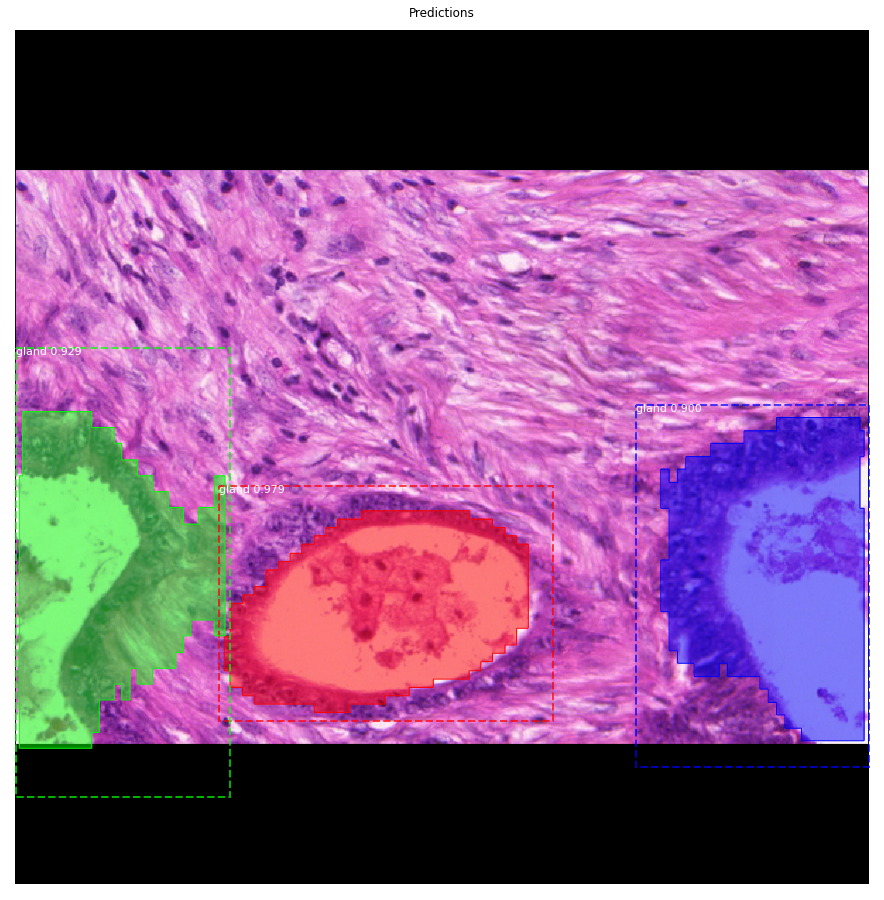

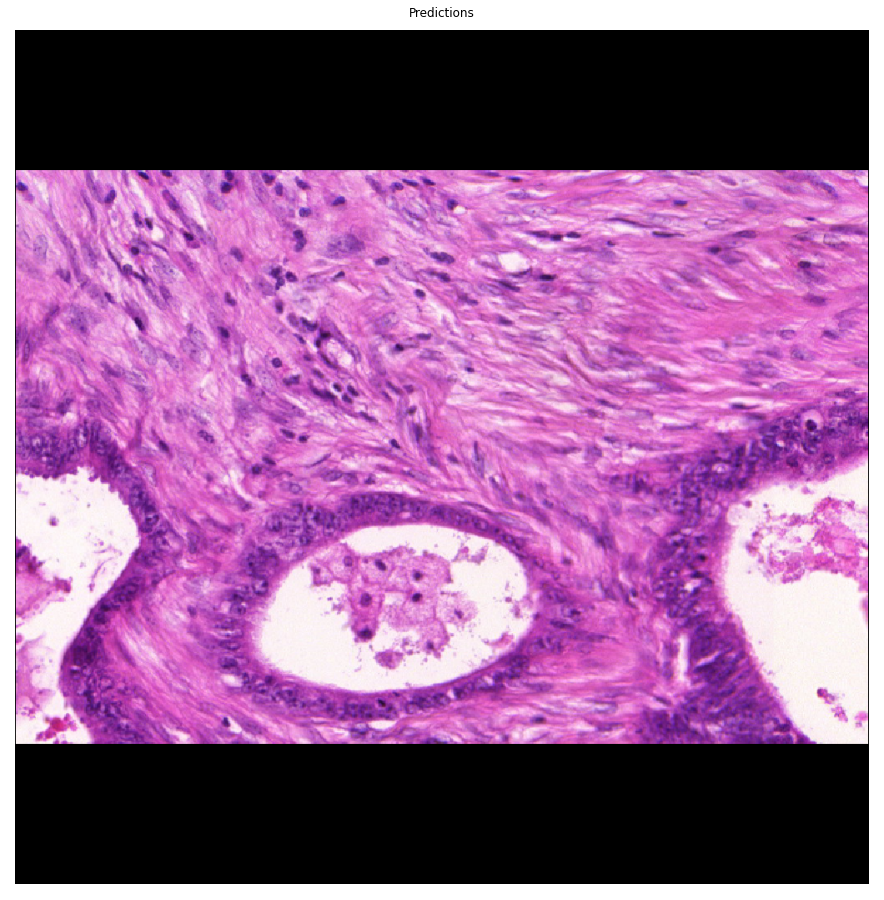

In [16]:
image_id = random.choice(dataset1.image_ids)
config.USE_MINI_MASK = True

# test for testA_52, testA_9
for model in models_resnet101:
    
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset1, config, image_id)

    info = dataset1.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset1.image_reference(image_id)))
    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset1.class_names, r['scores'], ax=ax,
                                title="Predictions")

image ID: gland.testA_19.bmp (16) /home/mkubita/Pulpit/projektBadawczy/Dataset_Model/val/testA_19.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 

image ID: gland.testA_19.bmp (16) /home/mkubita/Pulpit/projektBadawczy/Dataset_Model/val/testA_19.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min

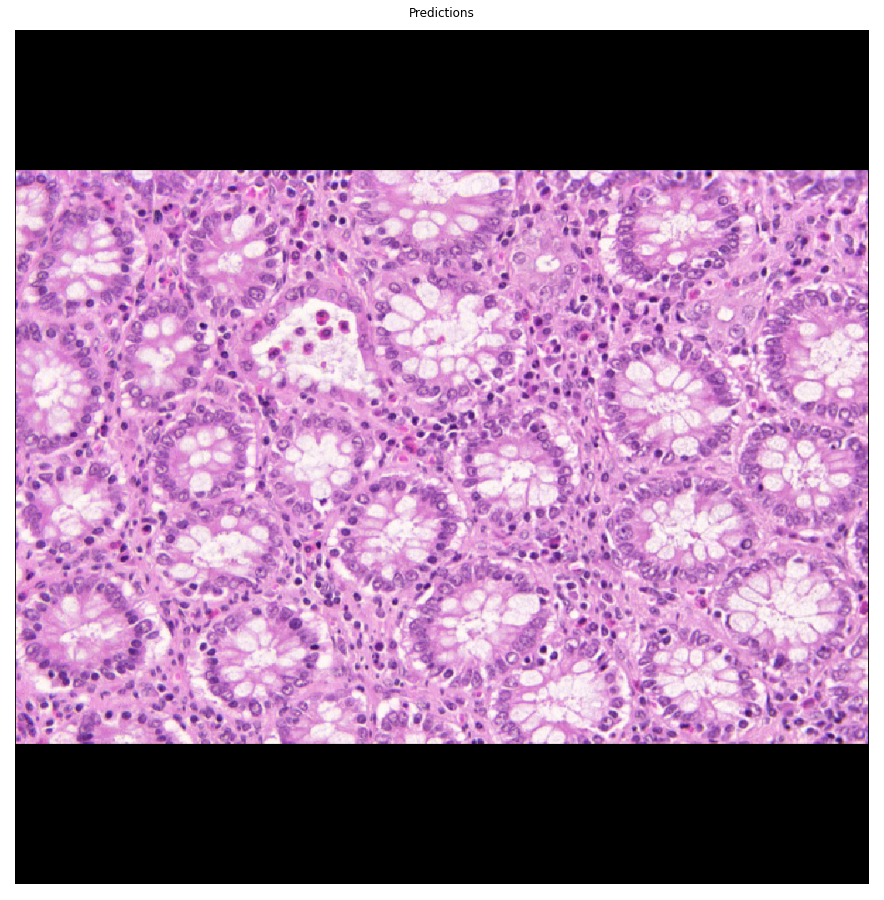

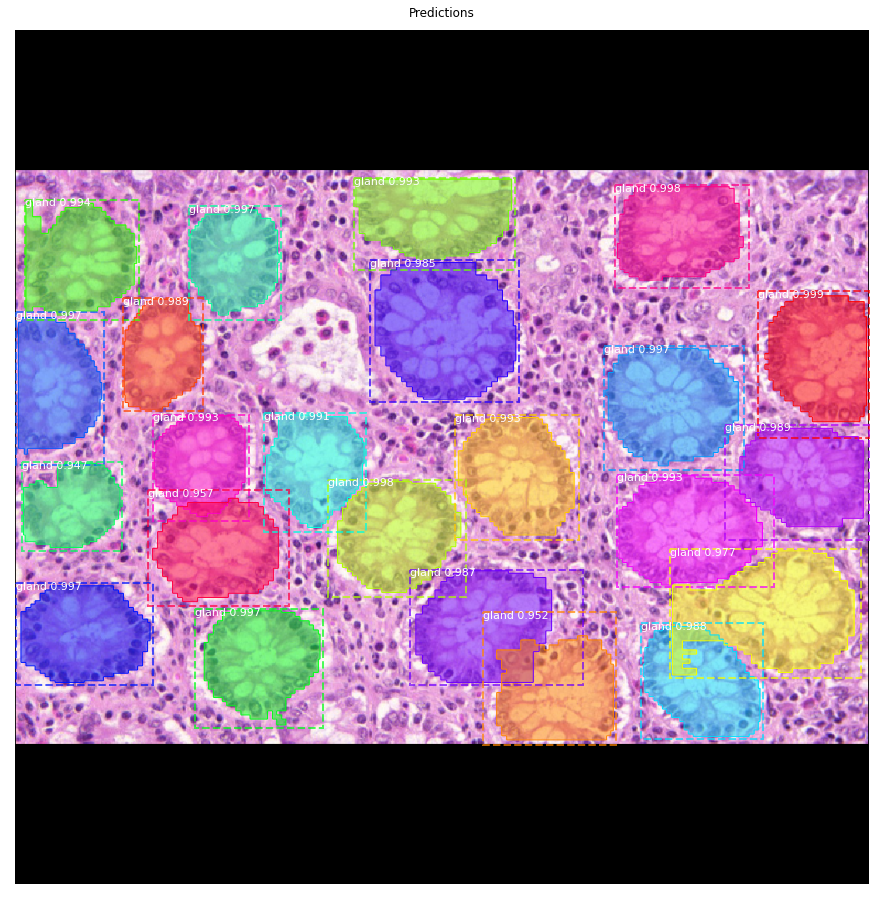

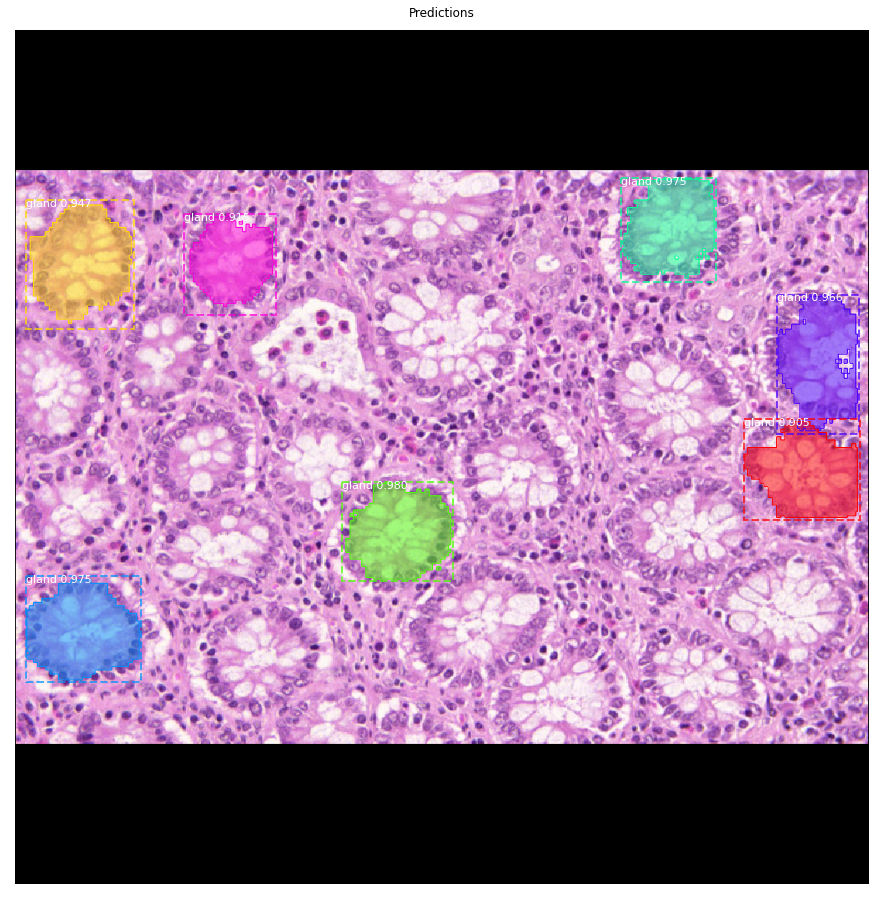

In [17]:
image_id = 16
for model in models:
    
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset1, config, image_id)

    info = dataset1.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset1.image_reference(image_id)))
    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset1.class_names, r['scores'], ax=ax,
                                title="Predictions")
# image_id = random.choice(dataset1.image_ids)
# image_id

## Calculate metrics

In [1]:
# Pick a set of random images
# image_ids = np.random.choice(dataset.image_ids, 20)
# for all test images
image_ids1 = dataset1.image_ids
image_ids2 = dataset2.image_ids

Metrics_Resnet50_1 = [compute_batch_ap(image_ids1, model, dataset1) for model in models]
Metrics_Resnet50_2 = [compute_batch_ap(image_ids2, model, dataset2) for model in models]

Metrics_Alexnet1 = [compute_batch_ap(image_ids1, model, dataset1) for model in models_alexnet]
Metrics_Alexnet2 = [compute_batch_ap(image_ids2, model, dataset2) for model in models_alexnet]

Metrics_Resnet101_1 = [compute_batch_ap(image_ids1, model, dataset1) for model in models_resnet101]
Metrics_Resnet101_2 = [compute_batch_ap(image_ids2, model, dataset2) for model in models_resnet101]

In [ ]:
#mAP
# mAP1 = [round(np.mean(Metrics_Resnet50_1[i][0]),3) for i, model in enumerate(models)]
# mAP2 = [round(np.mean(Metrics_Resnet50_2[i][0]),3) for i, model in enumerate(models)]

# mAP_Alexnet1 = [round(np.mean(Metrics_Alexnet1[i][0]),3) for i, model in enumerate(models_alexnet)]
# mAP_ALexnet2 = [round(np.mean(Metrics_Alexnet2[i][0]),3) for i, model in enumerate(models_alexnet)]

mAP_Resnet101_1 = [round(np.mean(Metrics_Resnet101_1[i][0]),3) for i, model in enumerate(models_resnet101)]
mAP_Resnet101_2 = [round(np.mean(Metrics_Resnet101_2[i][0]),3) for i, model in enumerate(models_resnet101)]

In [ ]:
#Jaccard
# Iou1 = [compute_batch_iou(image_ids1, model, dataset1) for model in models]
# Iou2 = [compute_batch_iou(image_ids2, model, dataset2) for model in models]

# Iou_Alexnet1 = [compute_batch_iou(image_ids1, model, dataset1) for model in models_alexnet]
# Iou_Alexnet2 = [compute_batch_iou(image_ids2, model, dataset2) for model in models_alexnet]

Iou_Resnet101_1 = [compute_batch_iou(image_ids1, model, dataset1) for model in models_resnet101]
Iou_Resnet101_2 = [compute_batch_iou(image_ids2, model, dataset2) for model in models_resnet101]

In [ ]:
# iou1 = [round(np.mean(Iou1[i]),3) for i, model in enumerate(models)]
# iou2 = [round(np.mean(Iou2[i]),3) for i, model in enumerate(models)]

# iou_alexnet1 = [round(np.mean(Iou_Alexnet1[i]),3) for i, model in enumerate(models_alexnet)]
# iou_alexnet2 = [round(np.mean(Iou_Alexnet2[i]),3) for i, model in enumerate(models_alexnet)]

iou_resnet101_1 = [round(np.mean(Iou_Resnet101_1[i]),3) for i, model in enumerate(models_resnet101)]
iou_resnet101_2 = [round(np.mean(Iou_Resnet101_2[i]),3) for i, model in enumerate(models_resnet101)]

In [ ]:
#Dice
# dice1 = [round(compute_dice_metric(iou), 3) for iou in iou1]
# dice2 = [round(compute_dice_metric(iou), 3)  for iou in iou2]

# dice_alexnet1 = [round(compute_dice_metric(iou), 3) for iou in iou_alexnet1]
# dice_alexnet2 = [round(compute_dice_metric(iou), 3)  for iou in iou_alexnet2]

dice_resnet101_1 = [round(compute_dice_metric(iou), 3) for iou in iou_resnet101_1]
dice_resnet101_2 = [round(compute_dice_metric(iou), 3)  for iou in iou_resnet101_2]

In [37]:
# Alexnet comparison
metrics = {'Models': ['Alexnet28', 'Alexnet56', 'Alexnet84'],
            'mAP_Dataset1': mAP_Alexnet1,
            'mAP_Dataset2': mAP_ALexnet2,
            'Jaccard_Dataset1': iou_alexnet1,
            'Jaccard_Dataset2': iou_alexnet2,
            'Dice_Dataset1': dice_alexnet1,
            'Dice_Dataset2': dice_alexnet2,

          }

df = pd.DataFrame(metrics)
df

Models  mAP_Dataset1  mAP_Dataset2  Jaccard_Dataset1  Jaccard_Dataset2  \
0  Alexnet28         0.241         0.174             0.237             0.185   
1  Alexnet56         0.347         0.259             0.314             0.185   
2  Alexnet84         0.385         0.402             0.388             0.329   

   Dice_Dataset1  Dice_Dataset2  
0          0.383          0.312  
1          0.478          0.312  
2          0.559          0.495

In [24]:
# Resnet50 comparison
metrics = {'Models': ['Resnet28', 'Resnet56', 'Resnet84'],
            'mAP_Dataset1': mAP1,
            'mAP_Dataset2': mAP2,
            'Jaccard_Dataset1': iou1,
            'Jaccard_Dataset2': iou2,
            'Dice_Dataset1': dice1,
            'Dice_Dataset2': dice2,

          }

df = pd.DataFrame(metrics)
df

Models  mAP_Dataset1  mAP_Dataset2  Jaccard_Dataset1  Jaccard_Dataset2  \
0  Resnet28         0.227         0.122             0.227             0.156   
1  Resnet56         0.628         0.673             0.624             0.598   
2  Resnet84         0.190         0.104             0.182             0.106   

   Dice_Dataset1  Dice_Dataset2  
0          0.370          0.270  
1          0.768          0.748  
2          0.308          0.192

In [ ]:
# Resnet101 comparison
metrics = {'Models': ['Resnet101_28', 'Resnet_56', 'Resnet101_84'],
            'mAP_Dataset1': mAP_Resnet101_1,
            'mAP_Dataset2': mAP_Resnet101_2,
            'Jaccard_Dataset1': iou_resnet101_1,
            'Jaccard_Dataset2': iou_resnet101_2,
            'Dice_Dataset1': dice_resnet101_1,
            'Dice_Dataset2': dice_resnet101_2,

          }

df = pd.DataFrame(metrics)
df

### TEST NO AUGMENTATION

In [29]:
image_ids1 = dataset1.image_ids
image_ids2 = dataset2.image_ids


Metrics_1 = [compute_batch_ap(image_ids1, model, dataset1) for model in models_no_augmentation]
Metrics_2 = [compute_batch_ap(image_ids2, model, dataset2) for model in models_no_augmentation]

In [30]:
mAP_1 = [round(np.mean(Metrics_1[i][0]),3) for i, model in enumerate(models_no_augmentation)]
mAP_2 = [round(np.mean(Metrics_2[i][0]),3) for i, model in enumerate(models_no_augmentation)]

/home/mkubita/Pulpit/projektBadawczy/Projekt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mkubita/Pulpit/projektBadawczy/Projekt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
Iou1 = [compute_batch_iou(image_ids1, model, dataset1) for model in models_no_augmentation]
Iou2 = [compute_batch_iou(image_ids2, model, dataset2) for model in models_no_augmentation]

In [35]:
iou_1 = [round(np.mean(Iou1[i]),3) for i, model in enumerate(models_no_augmentation)]
iou_2 = [round(np.mean(Iou2[i]),3) for i, model in enumerate(models_no_augmentation)]

/home/mkubita/Pulpit/projektBadawczy/Projekt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mkubita/Pulpit/projektBadawczy/Projekt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
dice_1 = [round(compute_dice_metric(iou), 3) for iou in iou_1]
dice_2 = [round(compute_dice_metric(iou), 3)  for iou in iou_2]

In [37]:
mAP_1, mAP_2, iou_1, iou_2, dice_1, dice_2 

([0.0, nan, 0.0],
 [nan, nan, 0.0],
 [0.0, nan, 0.0],
 [nan, nan, 0.0],
 [0.0, nan, 0.0],
 [nan, nan, 0.0])

In [148]:
metrics = {'Models': ['Resnet101', 'Resnet101_Data_Aug', 'Resnet50_Data_Aug', 'Alexnet_Data_Aug'],
            'mAP_Dataset1': mAP1,
            'mAP_Dataset2': mAP2,
            'Jaccard_Dataset1': iou1,
            'Jaccard_Dataset2': iou2,
            'Dice_Dataset1': dice1,
            'Dice_Dataset2': dice2,

          }

df = pd.DataFrame(metrics)
df

Models  mAP_Dataset1  mAP_Dataset2  Jaccard_Dataset1  \
0           Resnet101         0.482         0.335             0.480   
1  Resnet101_Data_Aug         0.496         0.540             0.502   
2   Resnet50_Data_Aug         0.628         0.673             0.624   
3    Alexnet_Data_Aug         0.347         0.259             0.314   

   Jaccard_Dataset2  Dice_Dataset1  Dice_Dataset2  
0             0.478          0.649          0.647  
1             0.568          0.668          0.724  
2             0.598          0.768          0.748  
3             0.185          0.478          0.312

In [18]:
def calculate_epoch_loss(file_path: str) -> tuple:
    metrics1 = {}
    for event in tf.compat.v1.train.summary_iterator(file_path):
        if event.step not in metrics1:
            metrics1[event.step] = {}
        if len(event.summary.value) != 0:
            metrics1[event.step][event.summary.value[0].tag] = event.summary.value[0].simple_value
    epoch_loss = list()
    epoch_rpn_class_loss = list()
    epoch_rpn_bbox_loss = list()
    epoch_mrcnn_class_loss = list()
    epoch_mrcnn_bbox_loss = list()
    epoch_mrcnn_mask_loss = list()

    for step, value in metrics1.items():
        epoch_loss.append(value['epoch_loss'])
        epoch_rpn_class_loss.append(value['epoch_rpn_class_loss'])
        epoch_rpn_bbox_loss.append(value['epoch_rpn_bbox_loss'])
        epoch_mrcnn_class_loss.append(value['epoch_mrcnn_class_loss'])
        epoch_mrcnn_bbox_loss.append(value['epoch_mrcnn_bbox_loss'])
        epoch_mrcnn_mask_loss.append(value['epoch_mrcnn_mask_loss'])
    
    return epoch_loss, epoch_rpn_class_loss, epoch_rpn_bbox_loss, epoch_mrcnn_class_loss, epoch_mrcnn_bbox_loss, epoch_mrcnn_mask_loss

In [24]:
f1 = "/home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101_data_augm/train/events.out.tfevents.1652474449.k-mkubita01.294948.10318.v2"    
f2 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet50_data_agu/gland20220507T1203/train/events.out.tfevents.1651917821.k-mkubita01.57740.6867.v2'
f3 = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Alexnet_3_augmen_dropout/events.out.tfevents.1653326469.57770d500b4e'

In [25]:
loss1, class_loss1, rpn_bbox_loss1, mrcnn_class_loss1, mrcnn_bbox_loss1, mrcnn_mask_loss1 = calculate_epoch_loss(f1)
loss2, class_loss2, rpn_bbox_loss2, mrcnn_class_loss2, mrcnn_bbox_loss2, mrcnn_mask_loss2 = calculate_epoch_loss(f2)
loss3, class_loss3, rpn_bbox_loss3, mrcnn_class_loss3, mrcnn_bbox_loss3, mrcnn_mask_loss3 = calculate_epoch_loss(f3)

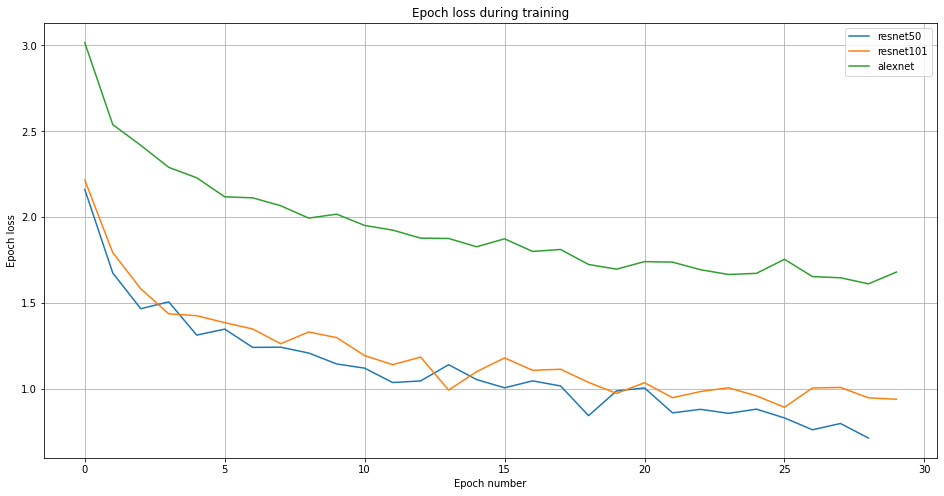

In [26]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.legend({'resnet101', 'resnet50', 'alexnet'})
plt.title('Epoch loss during training')
plt.xlabel('Epoch number')
plt.ylabel('Epoch loss')
plt.show()